# The review for steady-state entanglement


In [7]:
# run this unit first. this unit includes all functions that we used.

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import time
import math


# Operators
N = 2  # Two-level system for each emitter
Na = 6  # Cavity photon number truncation, make sure Na is much smaller than <a^+a>
sigma_1 = tensor(sigmam(), qeye(N), qeye(Na))  # Lowering operator for emitter 1
sigma_2 = tensor(qeye(N), sigmam(), qeye(Na))  # Lowering operator for emitter 2
N1 = sigma_1.dag() * sigma_1 
N2 = sigma_2.dag() * sigma_2
a = tensor(qeye(N), qeye(N), destroy(Na))  # Photon annihilation operator
S = sigma_1 + sigma_2  # Collective spin operator

# Initial and target states
psi_0 = tensor(basis(N, 0), basis(N, 1), basis(Na, 0))  # Initial state |100>
psi_S = (tensor(basis(N, 0), basis(N, 1)) - tensor(basis(N, 1), basis(N, 0))) / math.sqrt(2) 
# Target state |S>=(|10>-|01>)/sqrt(2)
    
# trace the cavity mose, we get effective operators without the cavity mode
sigma_1_eff = tensor(sigmam(), qeye(N))  # Effective lowering operator for emitter 1
sigma_2_eff = tensor(qeye(N), sigmam())  # Effective lowering operator for emitter 2
N1_eff = sigma_1_eff.dag() * sigma_1_eff
N2_eff = sigma_2_eff.dag() * sigma_2_eff
S_eff = sigma_1_eff + sigma_2_eff  # Effective collective operator
psi_0_eff = tensor(basis(N, 0), basis(N, 1))  # Effective initial state

# define functions to calculate the master equation
def sC_dynamics_full():
    H_full = delta * (N1 - N2) + Omega * (S + S.dag()) + g * (a * S.dag() + a.dag() * S)
    colps_full = [math.sqrt(gamma) * sigma_1, math.sqrt(gamma) * sigma_2, math.sqrt(kappa) * a]
    data_full = mesolve(H_full, psi_0, times, colps_full, [])
    F_full = [fidelity(psi_S, state.ptrace((0, 1))) for state in data_full.states]
    N_aa = [expect(a.dag() * a, state) for state in data_full.states]
    return F_full, N_aa

def sC_dynamics_eff():
    H_eff = delta * (N1_eff - N2_eff) + Omega * (S_eff + S_eff.dag())
    colps_eff = [math.sqrt(gamma) * sigma_1_eff, math.sqrt(gamma) * sigma_2_eff, math.sqrt(Gamma) * S_eff]
    data_eff = mesolve(H_eff, psi_0_eff, times, colps_eff, [])
    F_eff = [fidelity(psi_S, state) for state in data_eff.states]
    return F_eff

# steady-state functions
def sC_steadystate_full():
    H_full = delta * (N1 - N2) + Omega * (S + S.dag()) + g * (a * S.dag() + a.dag() * S)
    colps_full = [math.sqrt(gamma) * sigma_1, math.sqrt(gamma) * sigma_2, math.sqrt(kappa) * a]
    rho_ss_full = steadystate(H_full, colps_full)
    F_ss_full = fidelity(phi, rho_ss_full.ptrace((0, 1)))
    return F_ss_full

def sC_steadystate_eff():
    H_eff = delta * (N1_eff - N2_eff) + Omega * (S_eff + S_eff.dag())
    colps_eff = [math.sqrt(gamma) * sigma_1_eff, math.sqrt(gamma) * sigma_2_eff, math.sqrt(Gamma) * S_eff]
    rho_ss_eff = steadystate(H_eff, colps_eff)
    F_ss_eff = fidelity(phi, rho_ss_eff)
    return F_ss_eff

print('Functions are ready')


Functions are ready


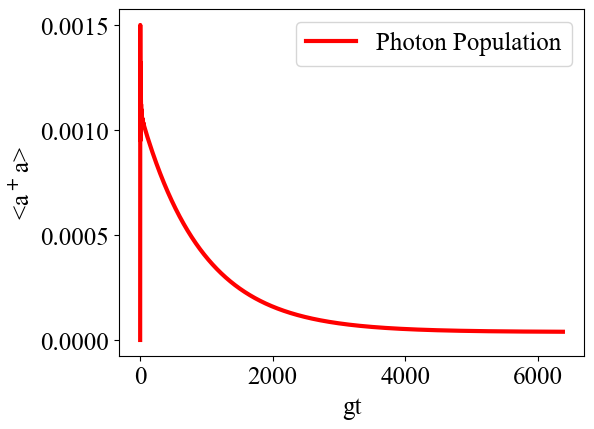

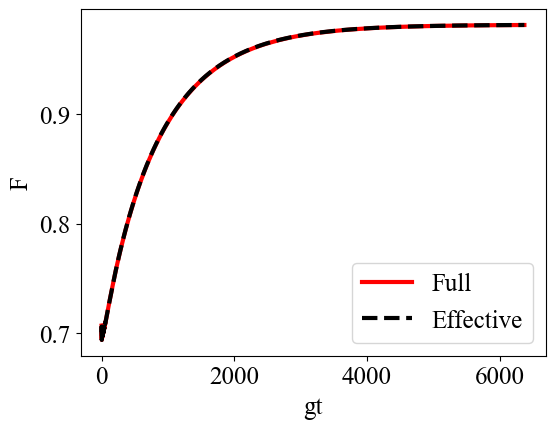

Running time: 134.96 s


In [9]:
# this unit is for the evolution of fidelity

# Start timing
start_time = time.time()

#parameters
g = 1  # Coupling strength, unit 1
delta = 0.2 * g  # Detuning, make sure delta << kappa
Omega = 1 * g  # driving frequency, make sure delta << kappa
kappa = 50 * g  # Cavity decay rate, kappa >> g, delta, Omega
C = 10**3  # Cooperativity.  C >> 1
gamma = g**2 / kappa / C  # Spontaneous emission rate
alpha = 2**0.5 * Omega / delta  # define alpha
Gamma = 4 * g**2 / kappa  # Decay induced by cavity
Gamma_eff = 2 * Gamma / (alpha**2 + 1)  # decay rate into state |D>

T = 20 / Gamma_eff  # Total simulation time based on effective decay
Nt = int(T * 50)  # Number of time steps
times = np.linspace(0, T, Nt)  # Time list for the simulation

# Calculate dynamics
F_full, N_aa = sC_dynamics_full()  # Full dynamics calculation
F_eff = sC_dynamics_eff()  # Effective dynamics calculation

# Plotting results
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
plt.figure(figsize=(6, 4.5))
plt.plot(times, N_aa, label='Photon Population', linewidth=3, linestyle='-', color='red')
plt.xlabel('gt')
plt.ylabel('<a$^+$a>')
plt.legend(loc='best')
plt.show()

plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
plt.figure(figsize=(6, 4.5))
plt.plot(times, F_full, label='Full', linewidth=3, linestyle='-', color='red')
plt.plot(times, F_eff, label='Effective', linewidth=3, linestyle='--', color='black')
plt.xlabel('gt')
plt.ylabel('F')
plt.legend(loc='best')
plt.show()

# Save the data
np.savetxt('sC_F_t.txt', np.column_stack((times, F_full, F_eff)), delimiter=' ')  # Writing data into the specified file

# End timing and print the execution time
execution_time = time.time() - start_time
print(f"Running time: {execution_time:.2f} s")


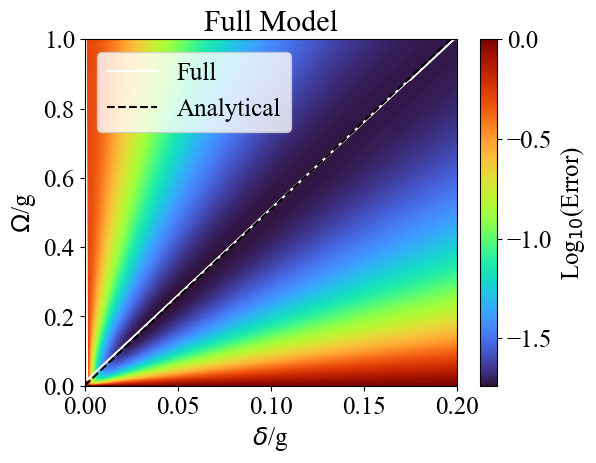

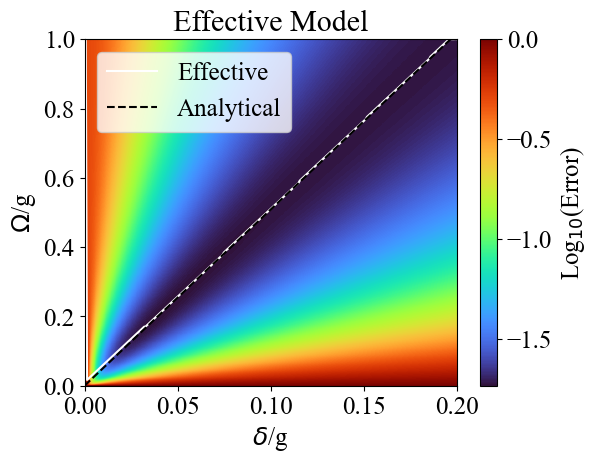

Running time: 319.60 s


In [45]:
# error versus delta and Omega, find the optimal alpha

# Start timing
start_time = time.time()

#parameters
g = 1  # Coupling strength, unit 1
kappa = 20 * g  # Cavity decay rate, larger than g, delta, Omega
C = 10**3  # Cooperativity
gamma = g**2 / kappa / C  # Spontaneous emission rate
M = 300  # The number of data points for delta and Omega
ddelta = np.linspace(0, kappa/100, M)  # Range of delta values
dOmega = np.linspace(0, kappa/20, M)  # Range of Omega values
epsilon_full = np.zeros((M, M))  # Array for full master equation errors
epsilon_eff = np.zeros((M, M))  # Array for effective master equation errors

# Perform calculations across a grid of delta and Omega values
for i in range(M):
    Omega = dOmega[i]
    for j in range(M):
        delta = ddelta[j]
        Gamma = 4 * g**2 / kappa
        epsilon_full[i, j] = 1 - sC_steadystate_full()  # Full master equation steady state fidelity
        epsilon_eff[i, j] = 1 - sC_steadystate_eff()  # Effective master equation steady state fidelity

# Determine optimal Omega values from numerical results
Omega_full = dOmega[np.argmin(epsilon_full, axis=0)]
Omega_eff = dOmega[np.argmin(epsilon_eff, axis=0)]

# Analytical solution
alpha_ana = (8 * C / 3)**0.25  # Analytical solution for optimal alpha
Omega_ana = alpha_ana * ddelta / 2**0.5  # Analytical solution for optimal Omega
Omega_ana = np.clip(Omega_ana, None, dOmega[-1])  # Ensure values do not exceed the plot range

# Visualization of the results for Full Model
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
fig, ax = plt.subplots(figsize=(6, 4.5))
heatmap = ax.imshow(np.log10(epsilon_full), extent=[ddelta[0], ddelta[-1], dOmega[0], dOmega[-1]], origin='lower', aspect='auto', cmap='turbo')
plt.colorbar(heatmap, label='Log$_{10}$(Error)')
ax.plot(ddelta, Omega_full, 'w-', label='Full')
ax.plot(ddelta, Omega_ana, 'k--', label='Analytical')
ax.legend(loc='best')
ax.set_xlabel('$\delta$/g')
ax.set_ylabel('$\Omega$/g')
plt.title('Full Model')
plt.show()

# Visualization of the results for Effective Model
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
fig, ax = plt.subplots(figsize=(6, 4.5))
heatmap = ax.imshow(np.log10(epsilon_eff), extent=[ddelta[0], ddelta[-1], dOmega[0], dOmega[-1]], origin='lower', aspect='auto', cmap='turbo')
plt.colorbar(heatmap, label='Log$_{10}$(Error)')
ax.plot(ddelta, Omega_eff, 'w-', label='Effective')
ax.plot(ddelta, Omega_ana, 'k--', label='Analytical')
ax.legend(loc='best')
ax.set_xlabel('$\delta$/g')
ax.set_ylabel('$\Omega$/g')
plt.title('Effective Model')
plt.show()

# save data in .txt file
combined_array = np.zeros((M+1, M+2)) # combine all data as one array
combined_array[1:, 0] = Omega_ana
combined_array[1:, 1] = ddelta
combined_array[0, 2:] = dOmega
combined_array[1:, 2:] = epsilon_full
file_path = 'sC_alpha_full.txt' # the adress and name
np.savetxt(file_path, combined_array, delimiter=' ') # write the data in the file

# save data in .txt file
combined_array = np.zeros((M+1, M+2)) # combine all data as one array
combined_array[1:, 0] = Omega_ana
combined_array[1:, 1] = ddelta
combined_array[0, 2:] = dOmega
combined_array[1:, 2:] = epsilon_eff
file_path = 'sC_alpha_eff.txt' # the adress and name
np.savetxt(file_path, combined_array, delimiter=' ') # write the data in the file

# Print the running time
execution_time = time.time() - start_time
print(f"Running time: {execution_time:.2f} s")



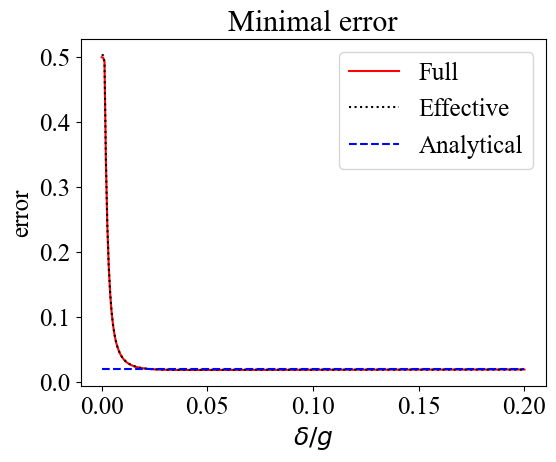

In [56]:
# minimal error from last heatmap, which prove that alpha is a single parameter
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
plt.figure(figsize=(6, 4.5))  # figure size

error_ana = np.linspace(1, 1, M) * (3/8/C)**0.5
error_full = np.min(epsilon_full, axis=0)
error_eff = np.min(epsilon_eff, axis=0)

plt.plot(ddelta, error_full, 'r-', label='Full')
plt.plot(ddelta, error_eff, 'k:', label='Effective')
plt.plot(ddelta, error_ana, 'b--', label='Analytical')
plt.xlabel('$\delta/g$')
plt.ylabel('error') 
plt.legend(loc='best')
plt.title('Minimal error')
plt.show()

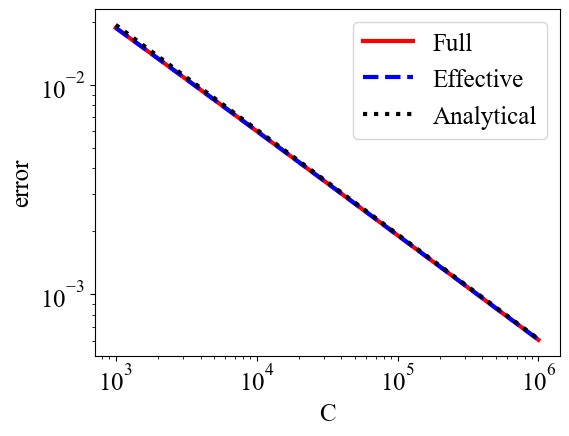

runing time：0.53 s


In [58]:
#This unit is for the scaling of cooperativity $C$

# Start timing
start_time = time.time()

# parameters
g = 1  # Coupling strength, unit 1
kappa = 20 * g  # Cavity decay rate, larger than g, delta, Omega
M = 100 # data point
log_dC = np.linspace(3, 6, M) # log10(C)
dC = np.power(10, log_dC) # run coorperivity from 1000 to 1000000
Omega = kappa / 30 # fixed Omega, ensure Omega << kappa
epsilon_full = np.zeros(M) # array for saving data
epsilon_eff = np.zeros(M) # array for saving data

# calculate
for j in range (M): 
    C = dC[j] # pick each cooperativity
    gamma = g**2 / kappa / C #emitter decay
    alpha = (8*C/3)**0.25 # optimal alpha
    delta = 2**0.5 * Omega / alpha # cooresponding delta with optimal alpha
    Gamma = 4 * g**2 / kappa  # Decay induced by cavity
    epsilon_full[j] = 1 - sC_steadystate_full() # solution from full master equation
    epsilon_eff[j] = 1 - sC_steadystate_eff() # solution from effective master equation
    
epsilon_ana = np.sqrt(3/8/dC)# analytical solution


# plot figure
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
plt.figure(figsize=(6, 4.5))  # figure size
plt.plot(dC, epsilon_full, label='Full', linewidth=3, linestyle='-', color='r')  
plt.plot(dC, epsilon_eff, label='Effective', linewidth=3, linestyle='--', color='b')  
plt.plot(dC, epsilon_ana, label='Analytical', linewidth=3, linestyle=':', color='k')
# show the log of axis
plt.xscale('log')
plt.yscale('log')
plt.xlabel('C')
plt.ylabel('error')
plt.tick_params(axis='both', which='major')
plt.legend(loc='best')
plt.show()


# save the data in .txt file
np.savetxt('sC_error_C.txt', np.column_stack((dC, epsilon_full, epsilon_eff, epsilon_ana)), delimiter=' ')

# end timing
end_time = time.time()
# print the time
execution_time = end_time - start_time
print(f"runing time：{execution_time:.2f} s")
